In [27]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [28]:
#设置种子和设备
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [29]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([-1,1], [0,1], 51, 51) #获取训练数据，第一个参数是x的取值范围，第二个参数是t的取值范围，第三个和第四个参数分别是x和t的采样点数
#这样，res是一个形状为(51*51,2)的数组，其中每一行代表一个(x,t)点的坐标，代表配位点/训练数据。b_left、b_right、b_upper和b_lower分别是边界条件的训练点，这些点用于训练PINNsformer模型。
res_test, _, _, _, _ = get_data([-1,1], [0,1], 256, 100) #生成测试数据，采样点数为101x101
#这样，res_test是一个形状为(101*101,2)的数组，代表测试数据

#将数据转换为时间序列，输入的数据形状为(N, 2)，第一列x第二列t。最后返回的是一个伪时间序列数据，形状为(N, num_step, 2)，step则代表Δt，是伪时间序列的递增量。相当于把N个[x,t]转换为{[x,t],[x,t+Δt],[x,t+2Δt],...,[x,t+(num_step-1)Δt]}，即每个空间位置都有一个时间序列。
res = make_time_sequence(res, num_step=5, step=1e-4) #配位点的时间序列数据，res形状变为(51*51, 5, 2)，即每个(x,t)点都有5个时间步的序列数据
b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #左边界条件的时间序列数据，b_left形状变为(51, 5, 2)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #右边界条件的时间序列数据，b_right形状变为(51, 5, 2)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #上边界条件的时间序列数据，b_upper形状变为(51, 5, 2)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #下边界条件的时间序列数据，b_lower形状变为(51, 5, 2)

#将数据转移到显卡上
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

#将数据分离为x和t的部分
x_res, t_res = res[:,:,0:1], res[:,:,1:2] #将res的第一列作为x，第二列作为t,这样x_res和t_res的形状都是(51*51, 5, 1)，即51*51个时间序列，每个(x,t)点都有5个时间步的序列数据
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2] #将b_left的第一列作为x，第二列作为t,这样x_left和t_left的形状都是(51, 5, 1)，即每个左边界点都有5个时间步的序列数据
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2] #将b_right的第一列作为x，第二列作为t,这样x_right和t_right的形状都是(51, 5, 1)，即每个右边界点都有5个时间步的序列数据
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2] #将b_upper的第一列作为x，第二列作为t,这样x_upper和t_upper的形状都是(51, 5, 1)，即每个上边界点都有5个时间步的序列数据
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2] #将b_lower的第一列作为x，第二列作为t,这样x_lower和t_lower的形状都是(51, 5, 1)，即每个下边界点都有5个时间步的序列数据

#初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
def init_weights(m):
    if isinstance(m, nn.Linear): #判断是否是线性层
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [30]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) #创建PINNsformer模型，模型输出维度为1，outputlayer模块的隐藏层维度为512，数据的特征嵌入维度为32，编码器和解码器的层数为1，注意力机制的头数为2

model.apply(init_weights) #初始化模型中线性层的权重和偏置
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

print(model) #打印模型结构
print(get_n_params(model)) #打印模型参数数量

PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

C:\Users\lcy\AppData\Local\Temp\ipykernel_130328\4066470801.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [31]:
loss_track = [] #记录loss

for i in tqdm(range(500)): #训练500次
    def closure():
        pred_res = model(x_res, t_res) #得到配位点的预测结果
        pred_left = model(x_left, t_left) #得到左边界点的预测结果
        pred_right = model(x_right, t_right) #得到右边界点的预测结果
        pred_upper = model(x_upper, t_upper) #得到上边界点的预测结果
        pred_lower = model(x_lower, t_lower) #得到下边界点的预测结果

        #计算配位点的时间导数u_t和空间导数u_x
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        pred_x_upper = torch.autograd.grad(pred_upper, x_upper, grad_outputs=torch.ones_like(pred_upper), retain_graph=True, create_graph=True)[0]
        pred_x_lower = torch.autograd.grad(pred_lower, x_lower, grad_outputs=torch.ones_like(pred_lower), retain_graph=True, create_graph=True)[0]

        #计算损失，共三项损失
        loss_res = torch.mean((u_t + pred_res * u_x - 0.01/torch.pi * u_xx) ** 2)
        # loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        # loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower)**2)
        # loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
        loss_ic = torch.mean((pred_left[:,0] + torch.sin(torch.pi*x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 500/500 [07:32<00:00,  1.11it/s]


In [32]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinnsformer.pt')

Loss Res: 0.009217, Loss_BC: 0.000079, Loss_IC: 0.009186
Train Loss: 0.018482


relative L1 error: 1.299593
relative L2 error: 1.401970


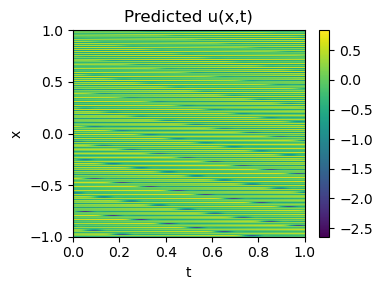

In [33]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(256,100)

mat = scipy.io.loadmat('./burgers_shock.mat')
u = mat['usol'].reshape(256,100)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,1,-1,1], aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()

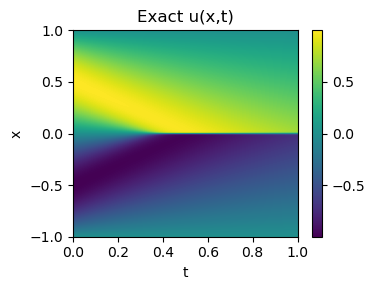

In [34]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,1,-1,1], aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_exact.png')
plt.show()

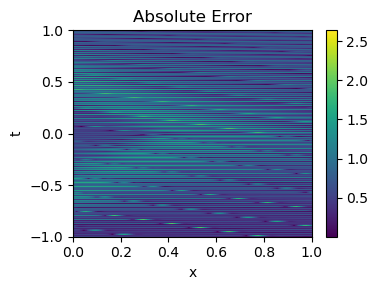

In [35]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,1,-1,1], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinnsformer_error.png')
plt.show()